# Exploration of the dataset with human balance evaluations

Marcos Duarte

Here is an exploration on the data set of quantitative and qualitative evaluations of 231 subjects available at [https://zenodo.org/record/47671](https://zenodo.org/record/47671).  
See the companiom data set website [http://demotu.org/datasets/balance/](http://demotu.org/datasets/balance/) for more details.

First, let's import the necessary Python libraries and configure the environment:

In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
import pandas as pd
pd.set_option('precision', 4)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.4,
                rc={'font.size': 16, 'lines.linewidth': 1, 'lines.markersize': 8, 'axes.titlesize': 'x-large'})
import glob
import sys, os
sys.path.insert(1, r'./../functions')

# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive

import qgrid  # pip install git+https://github.com/quantopian/qgrid
qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to /nbextensions folder
qgrid.set_defaults(remote_js=True, precision=2)  # Set default options by calling "set_defaults" (optional)

from AMTIbsf import loadbsf
from psd import psd
from hyperellipsoid import hyperellipsoid

## Load file with metadata about the data set

In [2]:
path = r'./../../../X/BDB/'
fname = 'BDSinfo.txt'
BDSinfo = pd.read_csv(os.path.join(path, fname), sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(BDSinfo.Subject)), BDSinfo.shape[0], BDSinfo.shape[1]))

Information of 231 subjects loaded (2742 rows, 55 columns).


In [3]:
#qgrid.show_grid(BDSinfo.iloc[:, :12])
BDSinfo.iloc[:, :15].head()

,Subject,Trial,Vision,Surface,Age,AgeGroup,Gender,Height,Weight,BMI,FootLen,Ystudy,Illness,PWD,Falls12m
0,1,BDS00001,Open,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0
1,1,BDS00002,Open,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0
2,1,BDS00003,Closed,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0
3,1,BDS00004,Closed,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0
4,1,BDS00005,Closed,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0


The BDSinfo file has 2742 rows for 231 subjects because there are 12 rows for each subject related to the 12 experimental trials (but there is a total of 30 trials missing). For now, to analyze the subjects's characteristics we can drop the additional rows for each subject:

In [4]:
info = BDSinfo.drop_duplicates(subset='Subject', inplace=False)
#qgrid.show_grid(info.iloc[:, :12])
info.iloc[:, :15].head()

,Subject,Trial,Vision,Surface,Age,AgeGroup,Gender,Height,Weight,BMI,FootLen,Ystudy,Illness,PWD,Falls12m
0,1,BDS00001,Open,Firm,48.4167,Young,M,171.5,73.9,25.1256,23.75,25,No,No,0
11,2,BDS00013,Open,Firm,33.0000,Young,F,157.5,54.2,21.8493,21.80,17,Yes,No,0
23,3,BDS00025,Open,Firm,27.5833,Young,F,154.0,44.0,18.5529,22.45,17,No,No,0
35,4,BDS00037,Open,Firm,49.7500,Young,M,178.1,80.7,25.4417,24.00,4,No,No,0
47,5,BDS00049,Closed,Firm,36.9167,Young,M,161.7,63.4,24.2476,23.10,11,No,No,0


## Age group and gender

Here are the number of subjetcs in the data set by age group and gender:

In [5]:
info = BDSinfo.drop_duplicates(subset='Subject', inplace=False)
print('Number of subjects per group (N=%d):' %len(info))
display(info[['Subject', 'AgeGroup', 'Gender']].groupby(['AgeGroup', 'Gender']).count())

Number of subjects per group (N=231):


Subject
AgeGroup Gender         
Old      F            75
         M            29
Young    F            63
         M            64

And the corresponding mean and standard deviation values:

In [7]:
print('Mean and SD age values across subjects per group and gender')
BDSinfo.groupby(['AgeGroup', 'Gender'])['Age'].agg([np.mean, np.std])

Mean and SD age values across subjects per group and gender


mean     std
AgeGroup Gender                 
Old      F       71.6767  6.8188
         M       69.9571  6.1755
Young    F       27.9828  7.7459
         M       30.7429  9.9758

## Disability and illness

Of the 231 subjects (115 young adults and 106 elderly adults), 22 of them were classified as a person with disability (PWD) and 142 subjects declared to have an illness:

In [8]:
display(info[['Subject', 'AgeGroup', 'PWD', 'Illness']].groupby(['AgeGroup', 'PWD', 'Illness']).count())

Subject
AgeGroup PWD Illness         
Old      No  No            14
             Yes           71
         Yes No             2
             Yes           17
Young    No  No            71
             Yes           50
         Yes No             2
             Yes            4

Because there were more disabilities in the older group, 16 vs. 6, let's select only people without disability for the comparison from now on:

In [9]:
info = info.ix[info.PWD=='No']

## Age, weight, height, and BMI 

Let's visualize the age, weight, height, and BMI values by gender of the subjects:

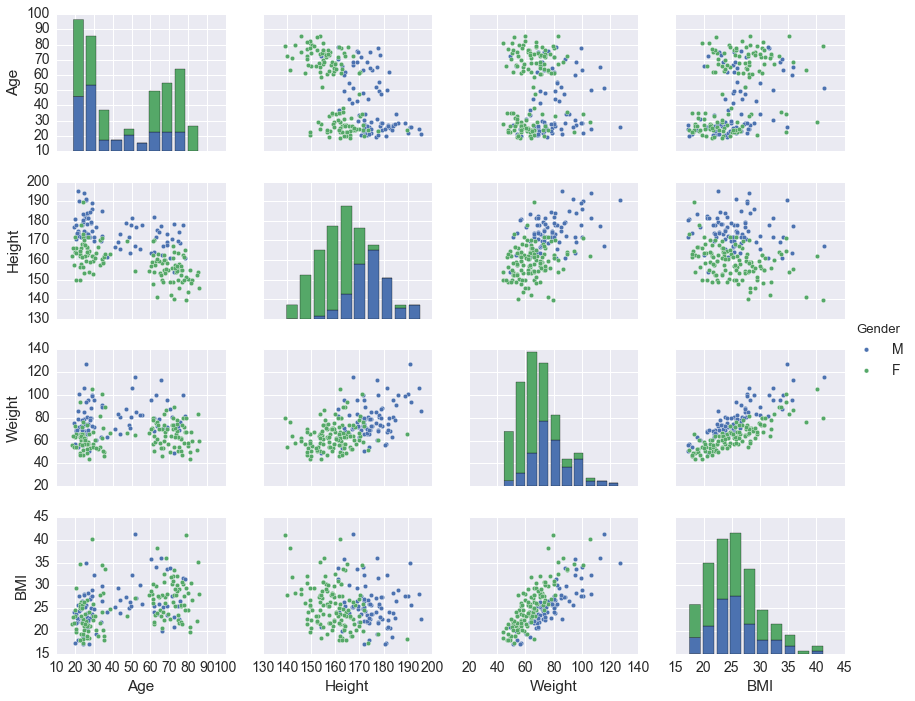

In [10]:
sns.pairplot(info[['Age', 'Gender', 'Height', 'Weight', 'BMI']], hue='Gender', size=2.5, aspect=1.2)
plt.show()

From figure above, we can see a biomodal distribution for the age characteristic; data are from young subjects, mostly between 20 and 30 yrs. old, and from elderly subjects, between 60 and 80 yrs. old. Men are slightly taller and heavier than women but they seem to have similar BMI.

## Fallers

Let's see how many subjects fell at least once in the last 12 months:

In [11]:
info[['AgeGroup', 'Falls12m']][info.Falls12m > 0].groupby(['AgeGroup']).count()

,Falls12m
AgeGroup,
Old,25
Young,28


So, surprisingly the number of young and elderly subjects who fell at least once in the last 12 months are similar (28% of tle elderly adults and 23% of the young adults fell).

 ## Qualitative evaluations
 
 Let's see the results for the Short Falls Efficacy Scale International test (FES-I), Mini Balance Evaluation Systems Test (Mini-BESTest), International Physical Activity Questionnaire Short Version (IPAQ); and Trail Making Test (TMT).
 
 The IPAQ data scores are coded as 'Low', 'Moderate' and 'High'; let's convert to numbers, '0', '1' and '2', for comparing with the other evaluations:

In [12]:
info.loc[info.IPAQ_S=='Low', 'IPAQ_S'] = 0
info.loc[info.IPAQ_S=='Moderate', 'IPAQ_S'] = 1
info.loc[info.IPAQ_S=='High', 'IPAQ_S'] = 2

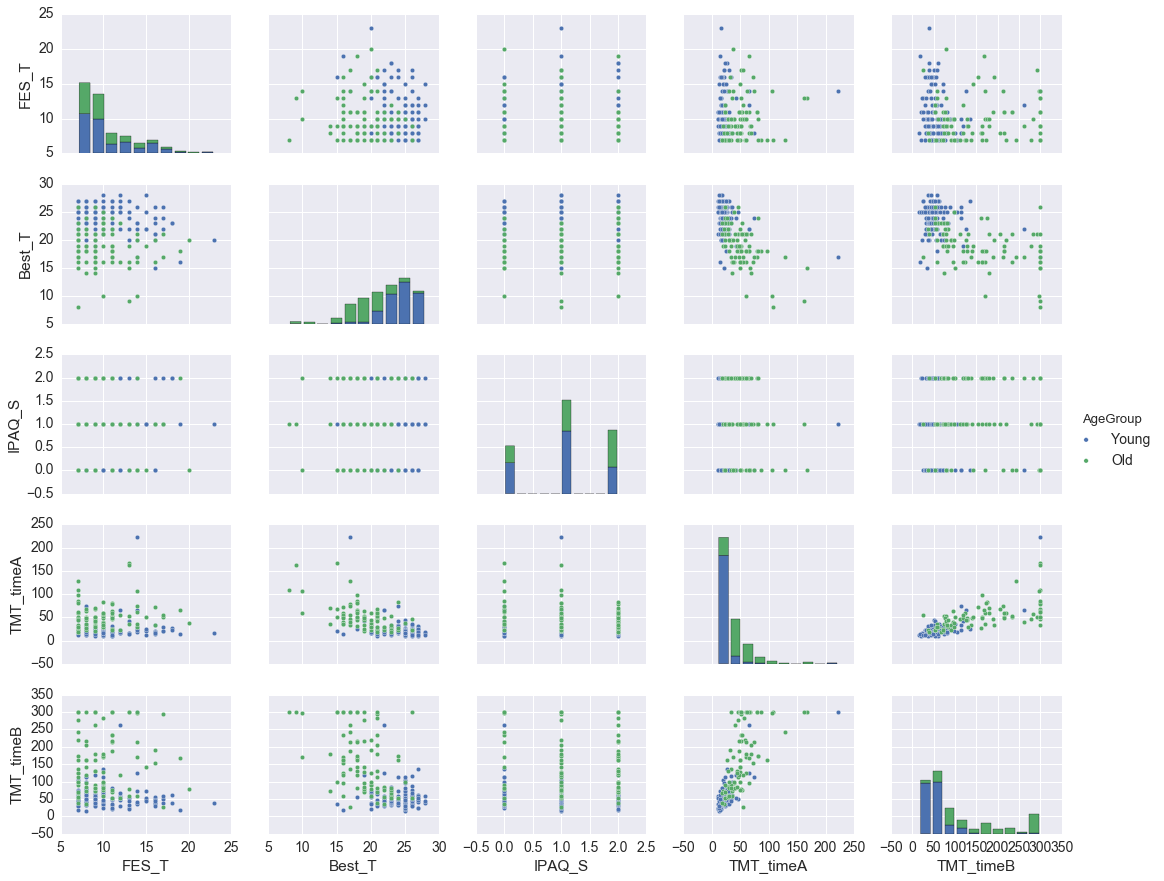

In [13]:
sns.pairplot(info[['AgeGroup', 'FES_T', 'Best_T', 'IPAQ_S', 'TMT_timeA', 'TMT_timeB']], hue='AgeGroup', aspect=1.2)
plt.show()

## Quantitative evaluation

The raw data from the stabilography evaluation, composed by the force platform signals plus the center of pressure (COP), in the anterior-posterior (ap), and medio-lateral (ml) directions, are stored in other files (2742 files!); the BSDinfo file just stores the names of these files according to subject's name and conditions.

So, we will have to open all these files and calculate some variables to quantify the stabilography data. The notexbook http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/Stabilography.ipynb describes some of the most typical measurements employed to quantify postural sway using the COP data. Let's calculate here the variables COP area and COP mean velocity.

In [16]:
fp = FloatProgress(min=0, max=len(BDSinfo.Trial)-1)
display(fp)
path = r'./../../../../Downloads/BDS/'
freq = 100
for i, fname in enumerate(BDSinfo.Trial):
    filename = os.path.join(path, fname + '.txt')
    fp.description = 'Reading data from file %s (%s/%s)' %(os.path.basename(filename), i+1, len(BDSinfo.Trial))
    fp.value = i
    grf = pd.read_csv(filename, delimiter=' ', skiprows=1, header=None,
                      names=['Time','Fx','Fy','Fz','Mx','My','Mz','COPx','COPy'], engine='c')   
    COP = grf[['COPx', 'COPy']].values
    # discard the first 5s for the accomodation period
    #COP = COP[5*mh.rate:, :]
    #grf = grf[5*mh.rate:, :]
    area, axes, angles, center, R = hyperellipsoid(COP, show=False)
    velo = np.sum(np.abs(np.sqrt(np.sum(np.diff(COP, axis=0)**2, axis=1))), axis=0)/(COP.shape[0]/freq)   
    BDSinfo.loc[i, 'COParea'] = area
    BDSinfo.loc[i, 'COPvelo'] = velo
    
data.to_csv(os.path.join(path, 'BDSinfoS.txt'), sep='\t')
data.to_excel(os.path.join(path, 'BDSinfoS.xlsx'))

In [17]:
qgrid.show_grid(BDSinfo[['Subject', 'Trial', 'AgeGroup', 'Vision', 'Surface', 'COParea', 'COPvelo']])

Let's once again do not consider the subjects with disabilities:

In [18]:
BDSinfo = BDSinfo.ix[BDSinfo.PWD=='No']

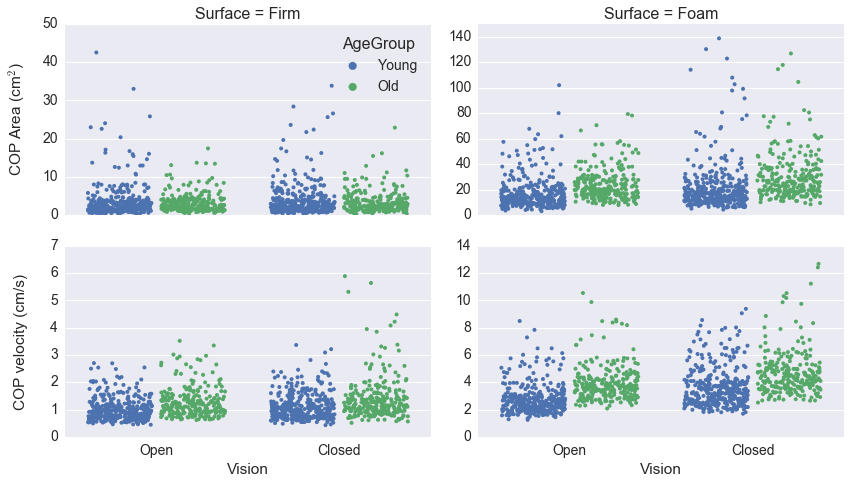

In [167]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Firm'],
               jitter=.35, split=True, size=4, ax=ax[0,0])
ax[0,0].set_ylim(0,50)
ax[0,0].set_xlabel('')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('COP Area (cm$^2$)')
ax[0,0].yaxis.set_label_coords(-.1, .5)
ax[0,0].legend(title='AgeGroup', loc='upper right')
ax[0,0].set_title('Surface = Firm', fontsize=16)

sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[0,1])
ax[0,1].set_ylim(0,150)
ax[0,1].set_xlabel('')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('')
ax[0,1].legend('')
ax[0,1].set_title('Surface = Foam', fontsize=16)

sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Firm'],
               jitter=.35, split=True, size=4, ax=ax[1,0])
ax[1,0].set_ylabel('COP velocity (cm/s)')
ax[1,0].yaxis.set_label_coords(-.1, .5)
ax[1,0].legend('')

sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo[BDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[1,1])
ax[1,1].set_ylabel('')
ax[1,1].legend('')
plt.tight_layout()
plt.show()

In [19]:
BDSinfo.groupby(['AgeGroup', 'Vision', 'Surface'])['COParea', 'COPvelo'].agg([np.mean, np.std])

COParea          COPvelo        
                            mean      std    mean     std
AgeGroup Vision Surface                                  
Old      Closed Firm      3.3316   2.8224  1.4170  0.7993
                Foam     30.3567  18.2976  4.6980  1.6269
         Open   Firm      3.2522   2.4977  1.2684  0.5345
                Foam     23.5564  12.4282  3.9408  1.3116
Young    Closed Firm      3.8891   4.3505  1.1136  0.4870
                Foam     21.3454  18.8459  3.6292  1.4324
         Open   Firm      3.5985   4.5430  1.0102  0.4196
                Foam     16.8073  12.2979  2.7343  1.0750

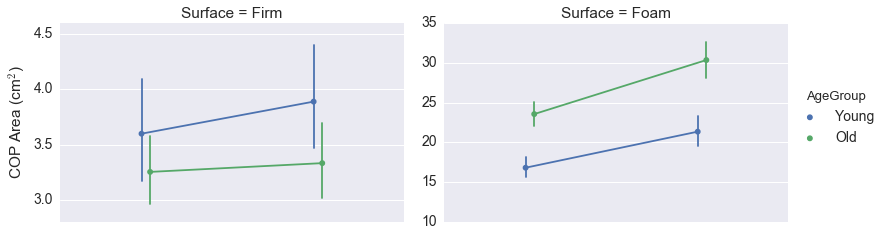

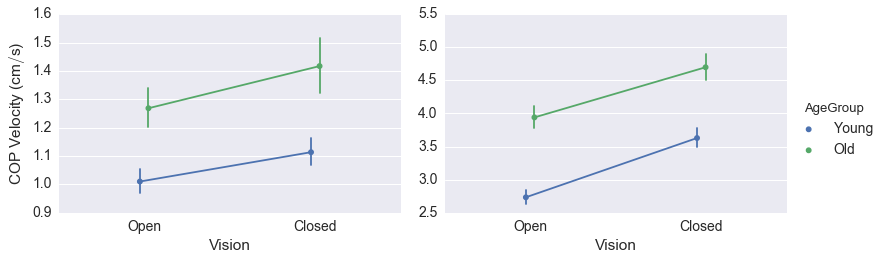

In [45]:
g0 = sns.factorplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo,
                    col='Surface', kind='point', dodge=True, sharey=False, size=4, aspect=1.4)
g0.set_xticklabels('')
g0.set_axis_labels('', 'COP Area (cm$^2$)')
g1 = sns.factorplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=BDSinfo,
                    col='Surface', kind='point', dodge=True, sharey=False, size=4, aspect=1.4)
g1.set_axis_labels('Vision', 'COP Velocity (cm$/$s)')
g1.set_titles('','')
plt.show()